# Model Selection
Research into choosing the right model

#### Imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

#### Preparing and loading data

In [45]:
df = pd.read_csv("datasets/Data Collection Smartphone Battery Life(Sheet1)_with_capacity_with_estimated_life.csv")
df = df.drop(columns=["Id"])


# change phoneos to 0 (iOs) and 1 (Android) 
df["phoneos"] = df["phoneos"].str.strip().str.lower().map({
    "ios": 0,
    "android": 1
})

# change all yes/no collumns in the data set to 1/0 booleans
yes_no_cols = [
    col for col in df.columns
    if df[col].astype(str).str.lower().isin(["yes", "no"]).any() and col != "phoneos"
]

for col in yes_no_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        "yes": 1,
        "no": 0
    })

# converting gender options to numerical values
df["usergender"] = df["usergender"].str.strip().str.lower().map({
    "man": 0,
    "woman": 1,
    "non-binary": 2,
    "prefer not to say": 3
})

target = "estimated_remaining_life_s" 
X = df.drop(columns=[target])
y = df[target]

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Defining, Validating and Testing Models

In [46]:
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Huber": HuberRegressor(),
    "SVR": SVR(kernel="rbf"),
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "GBR": GradientBoostingRegressor()
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    if name in ["Huber", "SVR", "KNN"]:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test

    mae_scores = -cross_val_score(model, X_train_used, y_train, cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    r2_scores = cross_val_score(model, X_train_used, y_train, cv=kf, scoring="r2", n_jobs=-1)

    model.fit(X_train_used, y_train)
    preds = model.predict(X_test_used)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "CV_MAE_Mean": mae_scores.mean(),
        "CV_MAE_Std": mae_scores.std(),
        "CV_R2_Mean": r2_scores.mean(),
        "CV_R2_Std": r2_scores.std(),
        "Test_MAE": mae,
        "Test_R2": r2
    })

    print(f"{name:15s} | CV MAE={mae_scores.mean():.3f} ±{mae_scores.std():.3f} | CV R²={r2_scores.mean():.3f} ±{r2_scores.std():.3f} | Test MAE={mae:.3f} | Test R²={r2:.3f}")

results_df = pd.DataFrame(results).sort_values(by="CV_MAE_Mean")

Ridge           | CV MAE=8912.382 ±3264.787 | CV R²=0.588 ±0.192 | Test MAE=6645.580 | Test R²=0.769
Lasso           | CV MAE=18505.132 ±12932.114 | CV R²=-0.688 ±2.082 | Test MAE=12750.858 | Test R²=0.060
ElasticNet      | CV MAE=9026.518 ±3831.571 | CV R²=0.587 ±0.241 | Test MAE=7124.402 | Test R²=0.701
Huber           | CV MAE=21690.937 ±6167.135 | CV R²=-0.656 ±0.742 | Test MAE=8269.039 | Test R²=0.659
SVR             | CV MAE=18405.791 ±4806.648 | CV R²=-0.169 ±0.047 | Test MAE=16644.975 | Test R²=-0.126


c:\Users\mats\Downloads\Challenge 1 - Phone Battery Life\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e+07, tolerance: 1.892e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\mats\Downloads\Challenge 1 - Phone Battery Life\.venv\Lib\site-packages\sklearn\linear_model\_huber.py:348: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


KNN             | CV MAE=17944.700 ±5956.971 | CV R²=-0.447 ±0.957 | Test MAE=17438.909 | Test R²=-0.332
RandomForest    | CV MAE=9253.766 ±4700.200 | CV R²=0.544 ±0.324 | Test MAE=7973.345 | Test R²=0.477
ExtraTrees      | CV MAE=8756.212 ±4465.961 | CV R²=0.633 ±0.295 | Test MAE=6973.305 | Test R²=0.562
GBR             | CV MAE=9718.715 ±3785.069 | CV R²=0.496 ±0.333 | Test MAE=7630.160 | Test R²=0.383


#### Barchart visual

C:\Users\mats\AppData\Local\Temp\ipykernel_37544\85369457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=results_df, x="Model", y="CV_MAE_Mean", palette="viridis")
C:\Users\mats\AppData\Local\Temp\ipykernel_37544\85369457.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=results_df.sort_values(by="CV_R2_Mean", ascending=False), x="Model", y="CV_R2_Mean", palette="mako")


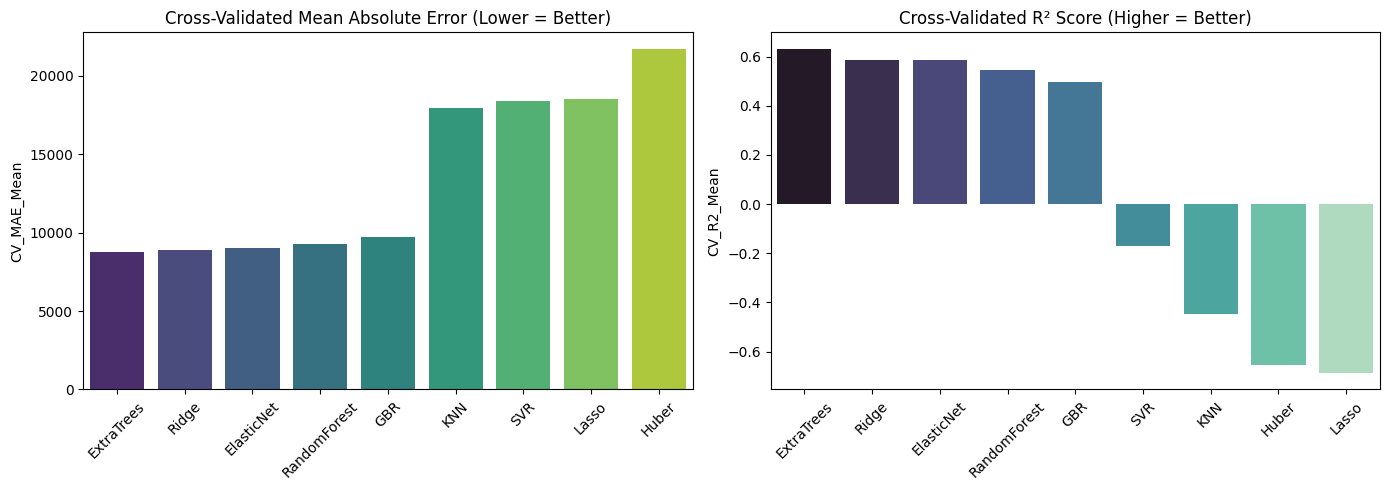

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(ax=axes[0], data=results_df, x="Model", y="CV_MAE_Mean", palette="viridis")
axes[0].set_title("Cross-Validated Mean Absolute Error (Lower = Better)")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], data=results_df.sort_values(by="CV_R2_Mean", ascending=False), x="Model", y="CV_R2_Mean", palette="mako")
axes[1].set_title("Cross-Validated R² Score (Higher = Better)")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Scatterplot visual


Top 3 models based on CV MAE: ['ExtraTrees' 'Ridge' 'ElasticNet']


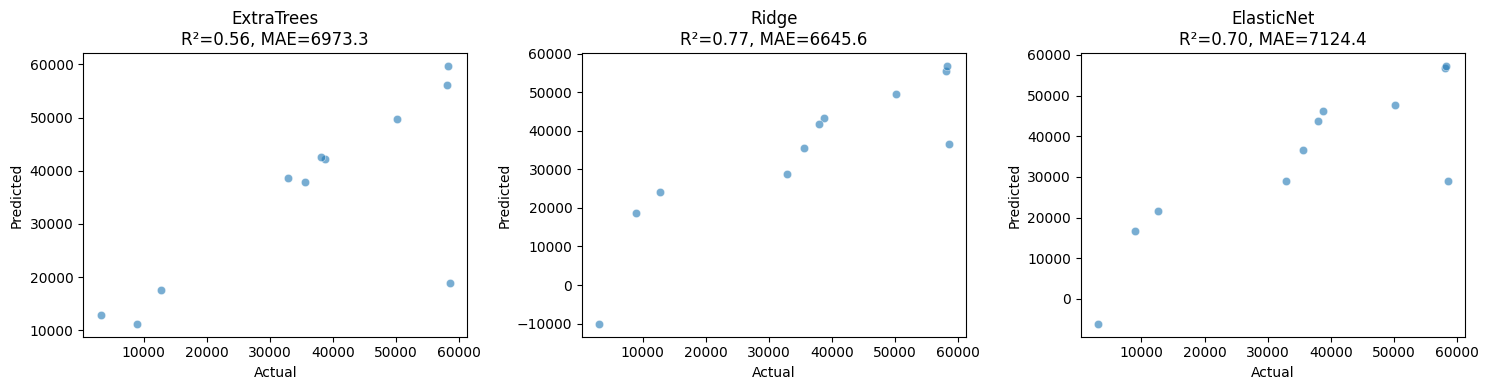

In [48]:
top3 = results_df.head(3)["Model"].values
print("\nTop 3 models based on CV MAE:", top3)

plt.figure(figsize=(15,4))
for i, name in enumerate(top3, 1):
    model = models[name]
    if name in ["Huber", "SVR", "KNN"]:
        preds = model.predict(X_test_scaled)
    else:
        preds = model.predict(X_test)
    
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name}\nR²={r2_score(y_test, preds):.2f}, MAE={mean_absolute_error(y_test, preds):.1f}")
plt.tight_layout()
plt.show()

#### Choosing the best hyperprams

In [49]:
param_grids = {
    "Ridge": {"alpha": [0.1, 1, 10, 100]},
    "Lasso": {"alpha": [0.001, 0.01, 0.1, 1, 10]},
    "ElasticNet": {"alpha": [0.001, 0.01, 0.1, 1], "l1_ratio": [0.2, 0.5, 0.8]},
    "RandomForest": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    "ExtraTrees": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    "GBR": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 5]}
}

best_params = {}
for name in top3:
    grid = GridSearchCV(models[name], param_grids.get(name, {}), cv=kf, scoring="neg_mean_absolute_error", n_jobs=-1)
    if name in ["Huber", "SVR", "KNN"]:
        grid.fit(X_train_scaled, y_train)
    else:
        grid.fit(X_train, y_train)
    
    best_params[name] = grid.best_params_

print("\nBest hyperparameters for top 3 models:")
for model, params in best_params.items():
    print(f"{model}: {params}")


Best hyperparameters for top 3 models:
ExtraTrees: {'max_depth': 20, 'n_estimators': 200}
Ridge: {'alpha': 1}
ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.2}
